In [8]:
import ROOT as r
import math
import array
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

from scipy.optimize import minimize
from scipy.signal import find_peaks

import numpy as np
from scipy.optimize import curve_fit

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


In [9]:
pas="1"
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
#dymin=-.984
#dymax=.9
#W2max=1.75
#dybgmin=-1.2
#dybgmax=1.2
#dxmin=-2
#dxmax=1
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Coin Min: 88 Coin Max: 100


In [10]:
import ROOT as r


def list_branches(rootfile_path, tree_name="Tout"):
    # Open the ROOT file
    root_file = r.TFile.Open(rootfile_path)
    
    # Check if the file was successfully opened
    if not root_file or root_file.IsZombie():
        print(f"Error: Could not open ROOT file '{rootfile_path}'.")
        return
    
    # Access the TTree
    tree = root_file.Get(tree_name)
    
    # Check if the tree exists
    if not tree:
        print(f"Error: Tree '{tree_name}' not found in file '{rootfile_path}'.")
        root_file.Close()
        return
    
    # Get the list of branches
    branch_list = tree.GetListOfBranches()
    
    # Print all branch names
    print(f"Branches in tree '{tree_name}':")
    for branch in branch_list:
        print(branch.GetName())
    
    # Close the ROOT file
    root_file.Close()

# Example usage
rootfile_path = "../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
list_branches(rootfile_path)


Branches in tree 'Tout':
runnum
WCut
pCut
nCut
fiduCut
coinCut
ebeam
nu
Q2
W2
dpel
ephi
etheta
pcentral
vz
vx
vy
xtgt
ytgt
thtgt
phtgt
thetabend
xfp
yfp
thfp
phfp
trP
trPx
trPy
trPz
ePS
xPS
eSH
xSH
ySH
eHCAL
xHCAL
yHCAL
xHCAL_exp
yHCAL_exp
dx
dy
ngrinch_hits
xGRINCH
yGRINCH
coin_time
hcal_time
bbcal_time
BPMAx
BPMAy
Rasterx
Rastery
Raster2x
Raster2y
helicity
IHWP
pblkid
tdc
atime
nblk
mag
run
tar
cblkid
cblkatime
cblktime
cblke
nclus
cid
cx
cy
catime
hodoTimes
hodoIDs
hodoTOT
nbars
meanTOT
trigger
triggerID
NdataTriggerID
hodoClusMean


Error in <THashList::Delete>: A list is accessing an object (0x3b31b5f0) already deleted (list name = THashList)


In [11]:
hodo=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/hodo1.npz")
trigger=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/trigger1.npz")
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/generic1.npz")
elasticSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{config}/simulation0.npz")
inelasticSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{config}/insimulation0.npz")
#hcal=np.load(f"media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/hcal.npz")
print(hodo.files)
print(trigger.files)
print(generic.files)
print(elasticSim.files)
print(inelasticSim.files)

['hodoTimes', 'hodoIDs', 'hodoTOT', 'nbars', 'hodoClusMean']
['trigger', 'triggerID', 'NdataTriggerID']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'coin_time']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP']


In [12]:
preshower=generic['ePS']
WW=generic['W2']

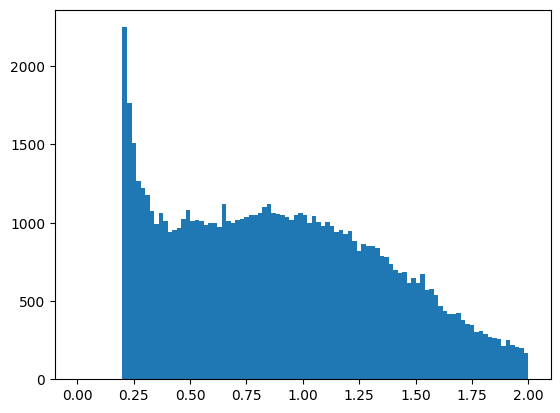

In [13]:
pshist=plt.hist(preshower[np.where(WW<2)],bins=100,range=(0,2))

In [14]:
features = elasticSim.files

# Combine all feature arrays into a single 2D array for each dataset
generic_data = np.column_stack([generic[key] for key in features])
elastic_data = np.column_stack([elasticSim[key] for key in features])
inelastic_data = np.column_stack([inelasticSim[key] for key in features])

# Add labels to the datasets
elastic_labels = np.ones((elastic_data.shape[0], 1))  # 1 for elastic
inelastic_labels = np.zeros((inelastic_data.shape[0], 1))  # 0 for inelastic

# Add labels as the last column
elastic_data_with_labels = np.hstack((elastic_data, elastic_labels))
inelastic_data_with_labels = np.hstack((inelastic_data, inelastic_labels))

# Combine labeled datasets
labeled_data = np.vstack((elastic_data_with_labels, inelastic_data_with_labels))

# If you need to work with generic data:
# It will remain unlabeled if not being used for training
# If labels for generic data exist, they can be added similarly
# generic_labels = ... (if available)
# generic_data_with_labels = np.hstack((generic_data, generic_labels))

# Optional: Shuffle the combined dataset
np.random.shuffle(labeled_data)

# Separate features (X) and labels (y)
X = labeled_data[:, :-1]  # All columns except the last one (features)
y = labeled_data[:, -1]   # The last column (labels)

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [17]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability for the "elastic" class

# Print evaluation metrics
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77     14804
         1.0       0.93      0.94      0.94     52995

    accuracy                           0.90     67799
   macro avg       0.85      0.85      0.85     67799
weighted avg       0.90      0.90      0.90     67799

AUC-ROC: 0.9415936051942315


In [18]:
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/generic1.npz")


In [19]:
stacked=np.empty(0)
coin=np.empty(0)
for i in range(0,13):  
    print(f"Starting File {i}")
    generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/generic{i}.npz")

    # Assume `actual_data` is a NumPy array with the same feature columns as X
    actual_data = np.column_stack([generic[key] for key in elasticSim.files])
    coin=np.append(coin,generic['coin_time'])
    # Predict probabilities
    elastic_probabilities = model.predict_proba(actual_data)[:, 1]

    # Save the results if needed
    generic_with_probabilities = np.hstack((actual_data, elastic_probabilities.reshape(-1, 1)))
    stacked=np.append(stacked,generic_with_probabilities)
    # Save to a file for inspection
np.save(f"/media/research/TOSHIBA EXT/GEn/ML/GEN{config}/genericWithProb{i}.npz", stacked)


Starting File 0
Starting File 1
Starting File 2
Starting File 3
Starting File 4
Starting File 5
Starting File 6
Starting File 7
Starting File 8
Starting File 9
Starting File 10
Starting File 11
Starting File 12


In [20]:
newStacked=stacked.reshape(25361701,13)

In [21]:
print(generic.files)

['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'coin_time']


In [22]:
newData=np.transpose(newStacked)

In [23]:
dx=newData[6]
dy=newData[7]
w2=newData[2]
prob=newData[-1]
trP=newData[-2]
coinTime=coin

# Possible background construction

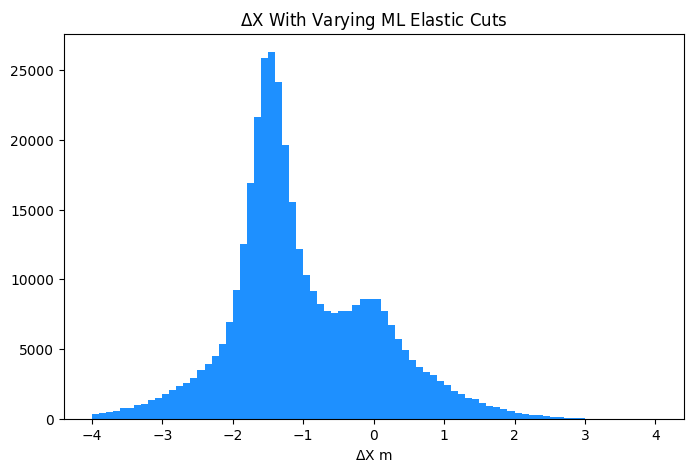

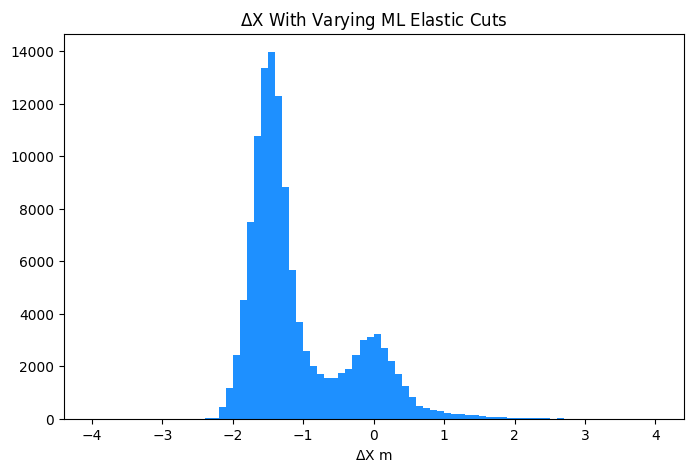

In [26]:
masknocut=np.where((coin > coinmin) & (coin < coinmax) & (w2<W2max) &(w2>W2min) & (prob>0/10))
figure=plt.figure(figsize=(8,5))
    
plt.xlabel("$\Delta$X m")
    
plt.title("$\Delta$X With Varying ML Elastic Cuts")
cut=plt.hist(dx[masknocut],bins=80,range=(-4,4),color='dodgerblue')

maskcut=np.where((coin > coinmin) & (coin < coinmax) & (w2<W2max) &(w2>W2min) & (prob>9/10))
figure=plt.figure(figsize=(8,5))
    
plt.xlabel("$\Delta$X m")
    
plt.title("$\Delta$X With Varying ML Elastic Cuts")
nocut=plt.hist(dx[maskcut],bins=80,range=(-4,4),color='dodgerblue')


In [29]:
nocut[0]-cut[0]

array([-3.2900e+02, -4.1200e+02, -4.8300e+02, -5.7500e+02, -7.6300e+02,
       -7.9200e+02, -9.9800e+02, -1.0790e+03, -1.3510e+03, -1.4850e+03,
       -1.7780e+03, -2.0730e+03, -2.3290e+03, -2.5920e+03, -2.9230e+03,
       -3.4720e+03, -3.8820e+03, -4.4730e+03, -4.9060e+03, -5.7960e+03,
       -6.7840e+03, -8.0490e+03, -9.4210e+03, -1.0864e+04, -1.2517e+04,
       -1.2329e+04, -1.1842e+04, -1.0791e+04, -9.8880e+03, -8.5210e+03,
       -7.7420e+03, -7.1640e+03, -6.5690e+03, -6.1710e+03, -6.0560e+03,
       -5.9410e+03, -5.7970e+03, -5.6740e+03, -5.5650e+03, -5.4400e+03,
       -5.3320e+03, -4.9940e+03, -4.4700e+03, -4.0260e+03, -3.6480e+03,
       -3.3720e+03, -3.2380e+03, -2.9540e+03, -2.7790e+03, -2.4460e+03,
       -2.1780e+03, -1.8190e+03, -1.6220e+03, -1.3680e+03, -1.2920e+03,
       -1.0220e+03, -8.5000e+02, -7.5500e+02, -6.2000e+02, -5.4200e+02,
       -3.7900e+02, -3.2500e+02, -2.5600e+02, -2.3300e+02, -1.7600e+02,
       -1.2800e+02, -7.6000e+01, -5.4000e+01, -4.4000e+01, -2.20

In [ ]:
for i in range(0,10):
    mask=np.where((coin > coinmin) & (coin < coinmax) & (w2<W2max) &(w2>W2min) & (prob>i/10))
    figure=plt.figure(figsize=(8,5))
    
    plt.xlabel("$\Delta$X m")
    
    plt.title("$\Delta$X With Varying ML Elastic Cuts")
    dxhist=plt.hist(dx[mask],bins=80,range=(-4,4),color='dodgerblue')
    plt.text(1,np.max(dxhist[0])/1.5,f"Cuts: {W2min}<W2<{W2max} \n {coinmin}<coincidence<{coinmax} \n ElasticProbability>{i/10}")


Text(1, 9308.666666666666, 'Cuts: -0.5<W2<1.7 \n 88<coincidence<100 \n ElasticProbability>1.2')

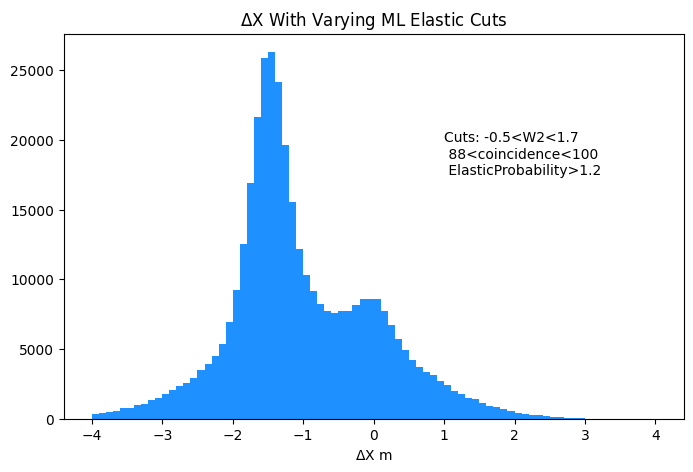

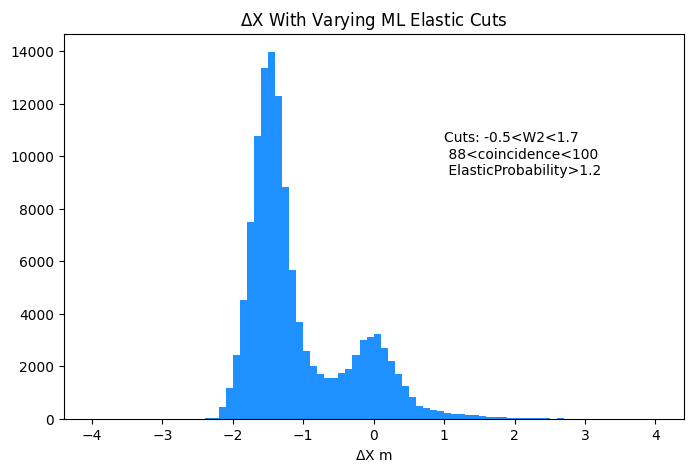

In [31]:
mask=np.where((coin > coinmin) & (coin < coinmax) & (w2<W2max) &(w2>W2min) & (prob>0/10))
figure=plt.figure(figsize=(8,5))
    
plt.xlabel("$\Delta$X m")
    
plt.title("$\Delta$X With Varying ML Elastic Cuts")
allHist=plt.hist(dx[mask],bins=80,range=(-4,4),color='dodgerblue')
plt.text(1,np.max(allHist[0])/1.5,f"Cuts: {W2min}<W2<{W2max} \n {coinmin}<coincidence<{coinmax} \n ElasticProbability>{i/10}")




mask=np.where((coin > coinmin) & (coin < coinmax) & (w2<W2max) &(w2>W2min) & (prob>9/10))
figure=plt.figure(figsize=(8,5))

plt.xlabel("$\Delta$X m")

plt.title("$\Delta$X With Varying ML Elastic Cuts")
elasticHist=plt.hist(dx[mask],bins=80,range=(-4,4),color='dodgerblue')
plt.text(1,np.max(elasticHist[0])/1.5,f"Cuts: {W2min}<W2<{W2max} \n {coinmin}<coincidence<{coinmax} \n ElasticProbability>{i/10}")


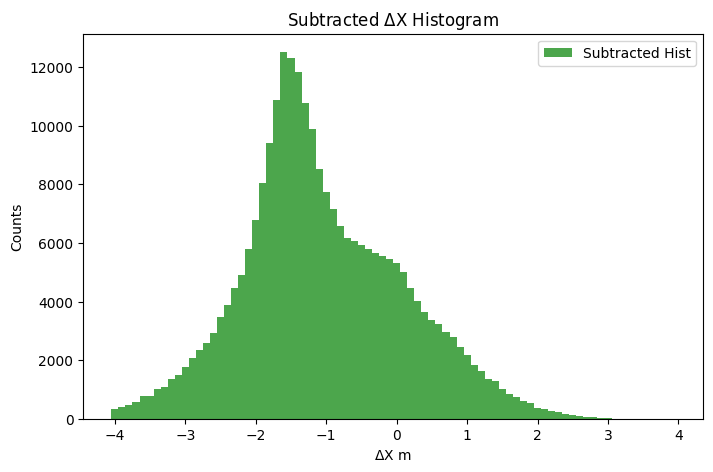

In [33]:
subtracted_bins = allHist[0] - elasticHist[0]

# Plot the subtracted histogram
figure = plt.figure(figsize=(8, 5))
plt.bar(allHist[1][:-1], subtracted_bins, width=(allHist[1][1] - allHist[1][0]), color='green', alpha=0.7, label="Subtracted Hist")
plt.xlabel("$\Delta$X m")
plt.ylabel("Counts")
plt.title("Subtracted $\Delta$X Histogram")
plt.legend()
plt.show()

In [ ]:
mask=np.where((coin > coinmin) & (coin < coinmax) & (dxmin<dx)&(dxmax>dx)&(dymin<dy)&(dymax>dy))
mask2=np.where((coin > coinmin) & (coin < coinmax) & (dxmin<dx)&(dxmax>dx)&(dymin<dy)&(dymax>dy)&(prob>.9))
plt.title("W2 with Elastic prob>.9")
plt.xlabel("W2 (GeV)")
w2hist=plt.hist(w2[mask],bins=80,color='dodgerblue',alpha=.5)
w2hist=plt.hist(w2,bins=80,color='magenta',alpha=.2)

w2hist=plt.hist(w2[mask2],bins=80,color='red',alpha=.5)
#plt.ylim(0,100000)
plt.yscale('log')

In [ ]:
coinhist=plt.hist(coinTime[np.where(prob>.9)],bins=80,range=(50,120),color='dodgerblue')
plt.title("Coin with Elastic prob>.9")
plt.xlabel("Coin (GeV)")

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('elastic_cuts_plots.pdf') as pdf:
    for i in range(0, 10):
        mask = np.where((coin > coinmin) & (coin < coinmax) & 
                        (w2 < W2max) & (w2 > W2min) & 
                        (prob > i / 10))
        
        figure = plt.figure(figsize=(8, 5))
        plt.xlabel("$\Delta$X m")
        plt.title("$\Delta$X With Varying ML Elastic Cuts")
        
        # Create the histogram
        dxhist = plt.hist(dx[mask], bins=80, range=(-4, 4), color='dodgerblue')
        
        # Add text annotations
        plt.text(1, np.max(dxhist[0]) / 1.5, 
                 f"Cuts: {W2min}<W2<{W2max} \n {coinmin}<coincidence<{coinmax} \n ElasticProbability>{i / 10}")
        
        # Save the current figure to the PDF
        pdf.savefig(figure)
        plt.close(figure)  # Close the figure to free memory


# ML Plots

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Inelastic (0)', 'Elastic (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall curve', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid()
plt.show()
